## Part 2: Indexing and Evaluation

In [1]:
import array
import collections
import csv
import datetime
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from collections import defaultdict
import time
from array import array
import math
from numpy import linalg as la

In [2]:
# Function to pre-process a tweet
def build_terms(line):

    filtered_line = line.lower() ## Transform in lowercase
    filtered_line = filtered_line.split() ## Tokenize the text to get a list of terms
    filtered_line = [re.sub(r'[^\w\s]', '', word) for word in filtered_line] # Removing non-words and non-whitespaces
    
    # Removing stop words
    stop_words = set(stopwords.words("english"))
    filtered_line = [word for word in filtered_line if word not in stop_words]  ## Eliminate the stopwords 

    # Stemming
    stemmer = PorterStemmer()
    filtered_line = [stemmer.stem(word) for word in filtered_line] ## Perform stemming

    return filtered_line

In [3]:
# Function to remove emoticons
def remove_emoticons(text):
    # Define a pattern to find all the emoticons
    emoticon_pattern = re.compile("[" u"\U0001F600-\U0001F64F" u"\U0001F300-\U0001F5FF" 
                                  u"\U0001F680-\U0001F6FF" u"\U0001F1E0-\U0001F1FF" 
                                  u"\U00002500-\U00002BEF" u"\U00002702-\U000027B0" 
                                  u"\U000024C2-\U0001F251" u"\U0001f926-\U0001f937" 
                                  u"\U00010000-\U0010ffff" u"\u2640-\u2642" 
                                  u"\u2600-\u2B55" u"\u200d" 
                                  u"\u23cf" u"\u23e9" 
                                  u"\u231a" u"\ufe0f" 
                                  u"\u3030" "]+", re.UNICODE)

    # Replace emoticons with an empty string
    text_without_emoticons = emoticon_pattern.sub('', text)

    return str(text_without_emoticons)

In [4]:
# Function to renove links
def remove_links(text):
    # Define a pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_links = url_pattern.sub('', text)

    return str(text_without_links)  

# PRE-PROCESS OF THE DOCUMENT

In [5]:
# Load the JSON data

with open('IRWA_data_2023/Rus_Ukr_war_data.json', 'r') as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]

tweet_information = {}
for line in lines:

        tweet_data = json.loads(line)

        # Clean the text
        tweet_text = tweet_data['full_text']
        tweet_text = remove_emoticons(tweet_text)
        tweet_text = remove_links(tweet_text)

        # Extract relevant information
        tweet_id = tweet_data['id_str']
        tweet_date = tweet_data['created_at']
        hashtags = [hashtag['text'] for hashtag in tweet_data['entities']['hashtags']]
        likes = tweet_data['favorite_count']
        retweets = tweet_data['retweet_count'] 
        twitter_username = tweet_data['user']['screen_name']
        tweet_url = f"https://twitter.com/{twitter_username}/status/{tweet_id}"

        processed_tweet = build_terms(tweet_text)

        # Store all the tweet information
        tweet_information[tweet_id] = {
            'Tweet ID': tweet_id,
            'Tweet Text': tweet_text,
            'Processed Tweet': processed_tweet,
            'Tweet Date': tweet_date,
            'Hashtags': hashtags,
            'Likes': likes,
            'Retweets': retweets,
            'Tweet_url': tweet_url
        }

# Map tweet IDs with document IDs for evaluation stage
tweet_document_ids_map = {}
tweet_document_ids_map1 = {}

with open('IRWA_data_2023/Rus_Ukr_war_data_ids.csv', 'r') as map_file:
    doc = csv.reader(map_file, delimiter='\t')
    for row in doc:
        doc_id, tweet_id = row
        tweet_document_ids_map[doc_id] = tweet_id
        tweet_document_ids_map1[tweet_id] = doc_id

# INDEXING

In [6]:
# Function to index creation
def create_index_tfidf(lines, num_documents):

    index = defaultdict(list)
    tf = defaultdict(list)  # term frequencies of terms in documents (documents in the same order as in the main index)
    df = defaultdict(int)  # document frequencies of terms in the corpus
    url_index = defaultdict(str)
    idf = defaultdict(float)

    for line in lines:
        tweet_data = json.loads(line)
        tweet_id = tweet_data['id_str']
        
        doc_id = tweet_document_ids_map1[tweet_id]
        terms = tweet_information[tweet_id]['Processed Tweet']
        url_index[doc_id] = tweet_information[tweet_id]['Tweet_url']

        current_page_index = {}

        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position)
            except:
                current_page_index[term] = [doc_id, array('I',[position])] #'I' indicates unsigned int (int in Python)

        norm = 0
        for term, posting in current_page_index.items():
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        for term, posting in current_page_index.items():
            tf[term].append(np.round(len(posting[1])/norm,4))
            df[term] += 1

        for term_page, posting_page in current_page_index.items():
            index[term_page].append(posting_page)

        for term in df:
            idf[term] = np.round(np.log(float(num_documents/df[term])), 4)

    return index, tf, df, idf, url_index

In [7]:
# Function to rank documents
def rank_documents(terms, docs, index, idf, tf, url_index):
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    
    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        query_vector[termIndex] = query_terms_count[term]/query_norm * idf[term]

        for doc_index, (doc, postings) in enumerate(index[term]):
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]

    # Cosine similarity
    doc_scores=[[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items() ]
    doc_scores.sort(reverse=True)
    result_docs = [x[1] for x in doc_scores]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    return result_docs, doc_scores

In [8]:
# Function to rank for specific queries using TF_IDF and to obtain the cosine_similarity
def search_tf_idf(query, index):
    query = build_terms(query)
    docs = set()
    for term in query:
        try:
            term_docs=[posting[0] for posting in index[term]]
            docs |= set(term_docs)
        except:
            pass
    docs = list(docs)
    ranked_docs, cosine_similarity = rank_documents(query, docs, index, idf, tf, url_index)
    return ranked_docs, cosine_similarity

In [9]:
start_time = time.time()
num_documents = len(lines)
index, tf, df, idf, url_index = create_index_tfidf(lines, num_documents)
print("Total time to create the index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the index: 156.27 seconds


In [11]:
q = True
while q == True:
    print("\nInsert your query or END to stop (i.e.: presidents visiting Kyiv):\n")
    query = input()
    print(query)
    if query == 'END':
        break
    ranked_docs, cosine_similarity = search_tf_idf(query, index)
    top = 10
    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
    for d_id in ranked_docs[:top]:
        print("doc_id = {} - tweet_url: {}".format(d_id, url_index[d_id]))


Insert your query or END to stop (i.e.: presidents visiting Kyiv):

Putin's speech

Top 10 results out of 918 for the searched query:

doc_id = doc_821 - tweet_url: https://twitter.com/Militarylandnet/status/1575817987558608896
doc_id = doc_40 - tweet_url: https://twitter.com/ChadwickHagan/status/1575913322754756608
doc_id = doc_607 - tweet_url: https://twitter.com/aeberman12/status/1575831841008889858
doc_id = doc_583 - tweet_url: https://twitter.com/SGNewsAlerts/status/1575835852152147969
doc_id = doc_930 - tweet_url: https://twitter.com/twarcorrespond/status/1575810113667207168
doc_id = doc_1040 - tweet_url: https://twitter.com/MoRaY1959/status/1575798982735204352
doc_id = doc_672 - tweet_url: https://twitter.com/WhereisRussia/status/1575826348178038786
doc_id = doc_683 - tweet_url: https://twitter.com/InformazioneA/status/1575825574710214656
doc_id = doc_47 - tweet_url: https://twitter.com/arq_trejo/status/1575912463945519105
doc_id = doc_3756 - tweet_url: https://twitter.com/Susp

In [12]:
# We used this code to compute the predicted_relevance of the csv files. We listed the documents we had for the query we wanted to compute and then run the code. 
# For this to work, you also have to run the cell above writing the corresponding query in order to compute the cosine similarities. 

# docs = ['doc_2052','doc_164','doc_411','doc_1805','doc_3442','doc_2657','doc_1534','doc_383','doc_1618','doc_63','doc_3803','doc_1069','doc_2852','doc_3445','doc_421','doc_3478','doc_3705','doc_3422','doc_650','doc_2442','doc_1452','doc_2908','doc_618','doc_2677','doc_489','doc_110','doc_3439','doc_3137','doc_3913','doc_2696','doc_2234','doc_2656','doc_3709','doc_592','doc_3556','doc_2586','doc_2701','doc_3478','doc_2956','doc_3552']
# for doc in docs:
#     for x in cosine_similarity:
#         if doc == x[1]:
#             print(x)
#             break
#         else:
#             if x == cosine_similarity[-1]:
#                 print([0.0, doc])
#                 break

# Evaluation

In [13]:
# Execute this one for the 'Evaluation_gt.csv'
search_results= pd.read_csv("Evaluation_gt.csv")

In [14]:
# Execute this one for the 'WeAreTheJudges.csv'
search_results = pd.read_csv("WeAreTheJudges.csv")

In [15]:
## Precision
def precision_at_k(doc_score, y_score, k=10):
    
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k]) #y_true
    relevant = sum(doc_score == 1)
    return float(relevant)/k

k = 10
for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]

    print("QUERY ", current_query)
    print("==> Precision@{}: {}\n".format(k, np.round(precision_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))

QUERY  5
==> Precision@10: 0.7

QUERY  4
==> Precision@10: 0.9

QUERY  3
==> Precision@10: 0.9

QUERY  2
==> Precision@10: 1.0

QUERY  1
==> Precision@10: 1.0



In [16]:
## Recall
def recall_at_k(doc_score, y_score, k=10):

    total_relevant = sum(doc_score == 1) 
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])  # y_true
    relevant = sum(doc_score == 1)
    
    # Avoid division by 0
    if total_relevant == 0:
        return 0

    return float(relevant) / total_relevant 

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]

    print("QUERY ", current_query)
    print("==> Recall@{}: {}\n".format(k, np.round(recall_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))

QUERY  5
==> Recall@10: 0.7

QUERY  4
==> Recall@10: 0.9

QUERY  3
==> Recall@10: 0.9

QUERY  2
==> Recall@10: 1.0

QUERY  1
==> Recall@10: 1.0



In [17]:
## Average Precision
def avg_precision_at_k(doc_score, y_score, k=10):
    gtp = sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]
    print("QUERY ", current_query)
    print("==> Average Precision@{}: {}\n".format(k, np.round(avg_precision_at_k(np.array(current_query_res["label"]), np.array(current_query_res["predicted_relevance"]), k),4)))


QUERY  5
==> Average Precision@10: 0.5831

QUERY  4
==> Average Precision@10: 0.8664

QUERY  3
==> Average Precision@10: 0.89

QUERY  2
==> Average Precision@10: 1.0

QUERY  1
==> Average Precision@10: 1.0



In [18]:
## F1-Score
def f1_score_at_k(doc_score, predicted_relevance, k=10):
    precision = precision_at_k(doc_score, predicted_relevance, k)
    recall = recall_at_k(doc_score, predicted_relevance, k)

    # Avoid division by zero
    if precision + recall == 0:
        return 0

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

for q in search_results['query_id'].unique():
    current_query = q
    current_query_res = search_results[search_results["query_id"] == current_query]
    
    print("QUERY ", current_query)
    print("==> F1-Score@{}: {}\n".format(k, np.round(f1_score_at_k(current_query_res["label"], current_query_res["predicted_relevance"], k),4)))

QUERY  5
==> F1-Score@10: 0.7

QUERY  4
==> F1-Score@10: 0.9

QUERY  3
==> F1-Score@10: 0.9

QUERY  2
==> F1-Score@10: 1.0

QUERY  1
==> F1-Score@10: 1.0



In [19]:
## Mean Average Precision (MAP)
def map_at_k(search_res, k=10):
    avp = []
    for q in search_res['query_id'].unique():  # loop over all query id
        curr_data = search_res[search_res['query_id'] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data['label']), np.array(curr_data['predicted_relevance']), k))  #append average precision for current query
    return sum(avp) / len(avp), avp  # return mean average precision

map_k, avp = map_at_k(search_results, k)
print("==> Mean Average Precision@{}: {}\n".format(k, np.round(map_k, 4)))


==> Mean Average Precision@10: 0.8679



In [20]:
## Mean Reciprocal Rank (MRR)
def rr_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

current_query_res = search_results[search_results["query_id"] == current_query]
print("==> Mean Reciprocal Rank@{}: {}\n".format(k, np.round(rr_at_k(np.array(current_query_res['label']), np.array(current_query_res['predicted_relevance']), k),4)))

==> Mean Reciprocal Rank@10: 1.0



In [21]:
## Normalized Discounted Cumulative Gain (NDCG)
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2**doc_score - 1   # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k

def ndcg_at_k(doc_score, y_score, k=10):
    dcg = dcg_at_k(doc_score, y_score, k)  # Calculate the actual DCG
    dcg_max = dcg_at_k(doc_score, doc_score, k)  # Calculate the ideal DCG (DCG_max)
    
    if not dcg_max:
        return 0  # Avoid division by zero
        
    ndcg = dcg / dcg_max  # Normalize the DCG by dividing by the ideal DCG
    return np.round(ndcg, 4)  # Return the NDCG score

ndcgs = []
for q in search_results['query_id'].unique(): # loop over all query ids
    labels = np.array(search_results[search_results['query_id'] == q]["label"]) ## get labels for current query
    scores = np.array(search_results[search_results['query_id'] == q]["predicted_relevance"]) # get predicted score for current query
    ndcgs.append(ndcg_at_k(labels, scores, k)) # append NDCG for current query

print("Average ndcg@{}: {}".format(k, np.round(sum(ndcgs) / len(ndcgs), 4)))

Average ndcg@10: 0.9228


In [22]:
# Extract relevant and non-relevant tweets for each query
relevant_doc = {}
non_relevant_doc = {}
for query_id in search_results['query_id'].unique():
    relevant_doc[query_id] = []
    non_relevant_doc[query_id] = []
    for index, row in search_results[search_results['query_id'] == query_id].iterrows():
        if row['label'] == 1:
            relevant_doc[query_id].append(row['doc'])
        else:
            non_relevant_doc[query_id].append(row['doc'])

relevant_tweets = {}
non_relevant_tweets = {}

all_relevant_tweets = []
all_relevant_nonrelevant_tweets = []

relevant_tweets_text = {}
non_relevant_tweets_text = {}

for query_id in search_results['query_id'].unique():
    relevant_tweets[query_id] = []
    non_relevant_tweets[query_id] = []
    for i in relevant_doc[query_id]:
       relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])
       all_relevant_tweets.append(tweet_information[tweet_document_ids_map[i]]['Processed Tweet'])
    for i in non_relevant_doc[query_id]:
       non_relevant_tweets[query_id].append([tweet_document_ids_map[i], tweet_information[tweet_document_ids_map[i]]['Processed Tweet']])
    relevant_tweets_text[query_id] = [' '.join(tweet_info[1]) for tweet_info in relevant_tweets[query_id]]
    non_relevant_tweets_text[query_id] = [' '.join(tweet_info[1]) for tweet_info in non_relevant_tweets[query_id]]
    all_relevant_nonrelevant_tweets.append(relevant_tweets_text[query_id]+non_relevant_tweets_text[query_id])

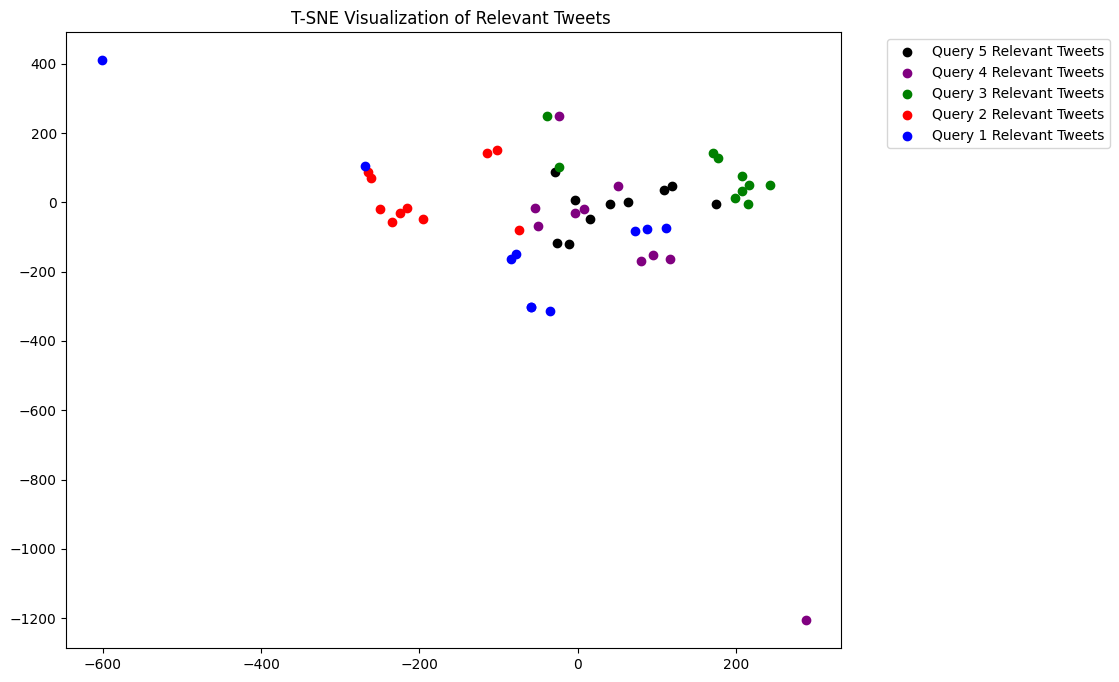

In [23]:
all_relevant_t = []
for element in all_relevant_tweets:
    all_relevant_t.append(', '.join(element).replace(",", ""))

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(all_relevant_t)

# T-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tsne_result = tsne.fit_transform(tfidf_matrix.toarray())

tsne_result_query = {}
length = len(relevant_tweets[search_results['query_id'].unique()[0]])

for query_id in search_results['query_id'].unique():
    if query_id == search_results['query_id'].unique()[0]:
        tsne_result_query[query_id] = tsne_result[:length]
    elif query_id == search_results['query_id'].unique()[-1]:
        tsne_result_query[query_id] = tsne_result[length:]
    else:
        tsne_result_query[query_id] = tsne_result[length:length + len(relevant_tweets[query_id])]
        length += len(relevant_tweets[query_id])

# Visualization with different colors for each query
colors = ['blue', 'red', 'green', 'purple', 'black']
plt.figure(figsize=(10, 8))
for query_id in search_results['query_id'].unique():
    plt.scatter(tsne_result_query[query_id][:, 0], tsne_result_query[query_id][:, 1], marker='o', color=colors[query_id-1], label='Query {} Relevant Tweets'.format(query_id))


plt.title('T-SNE Visualization of Relevant Tweets ')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

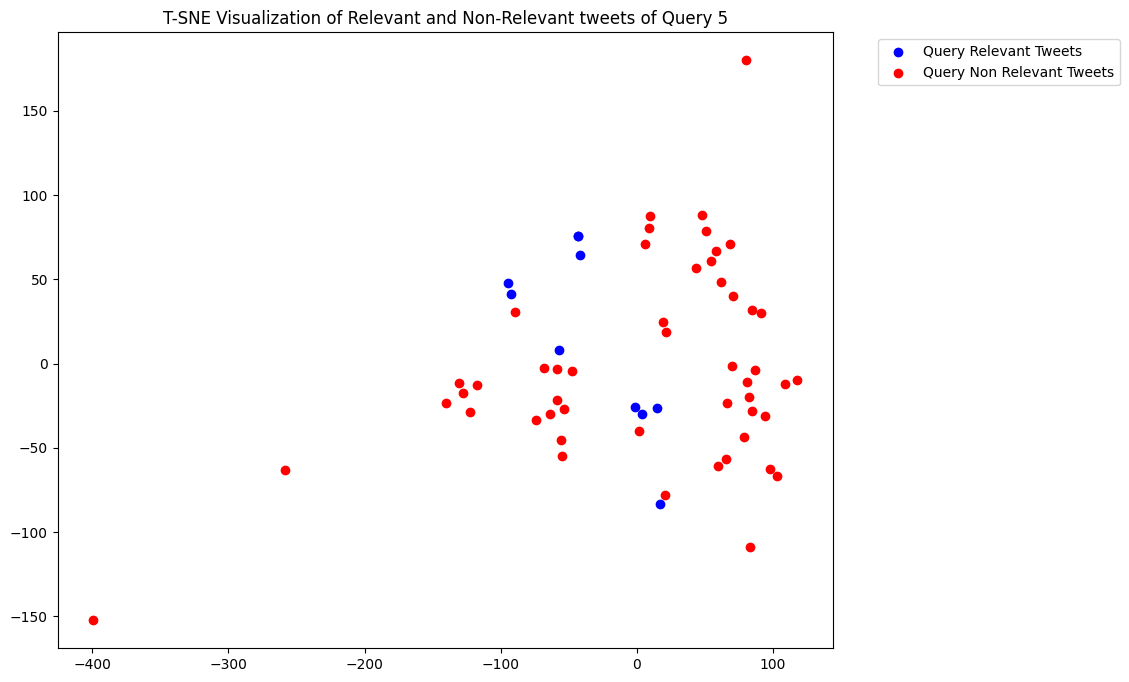

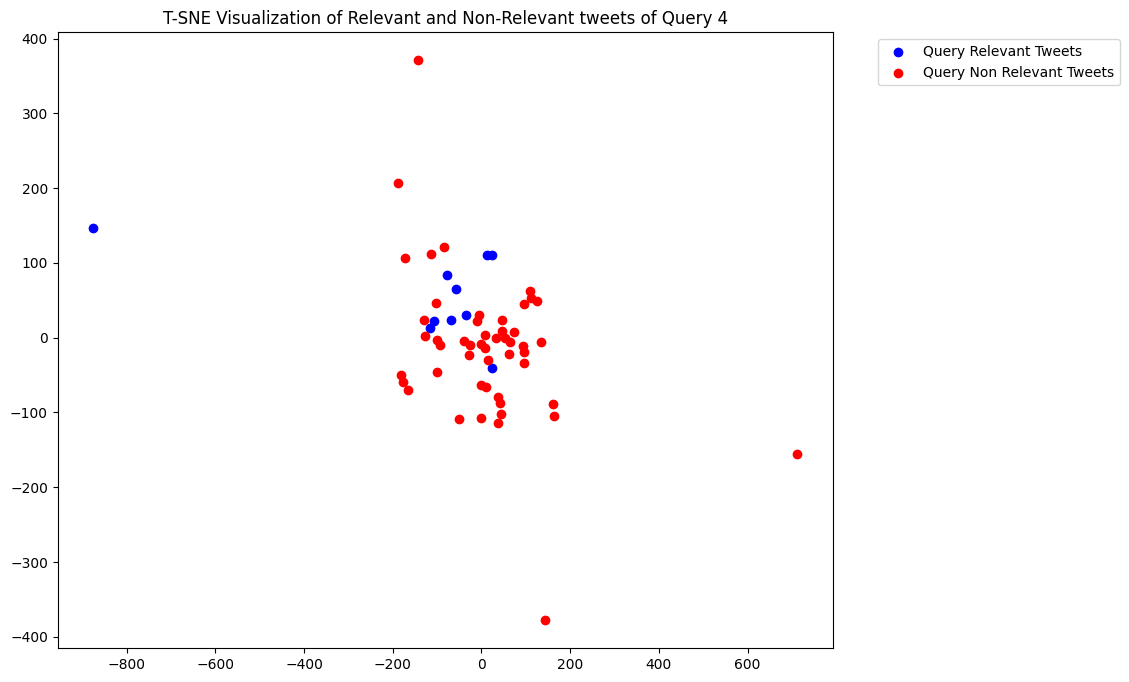

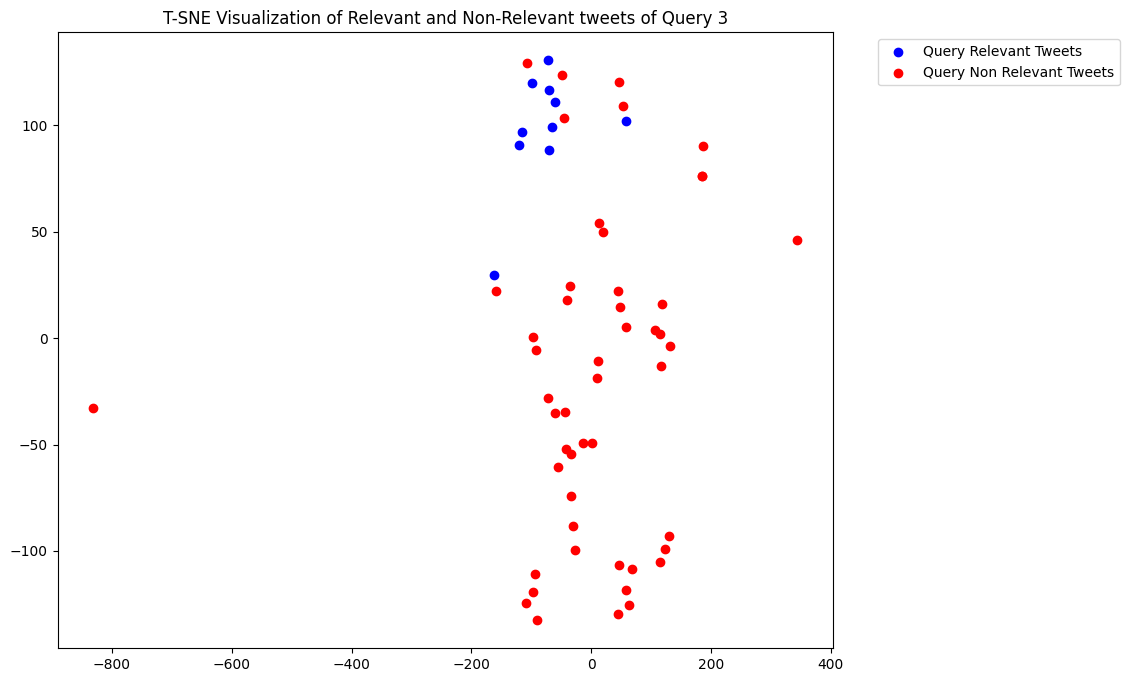

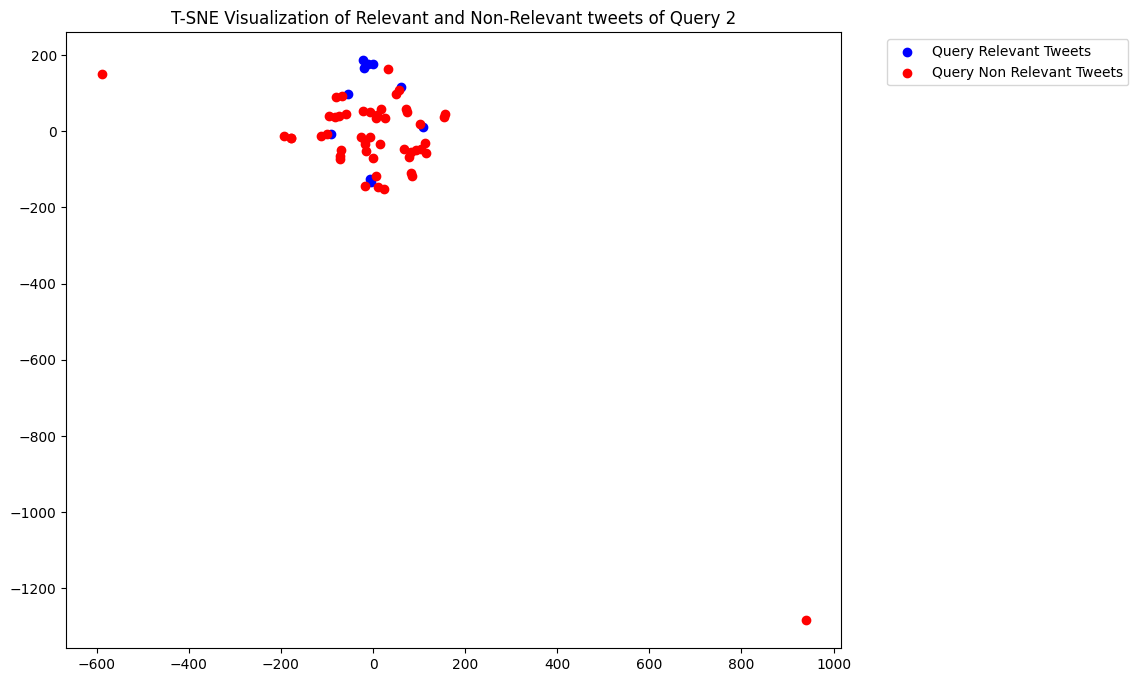

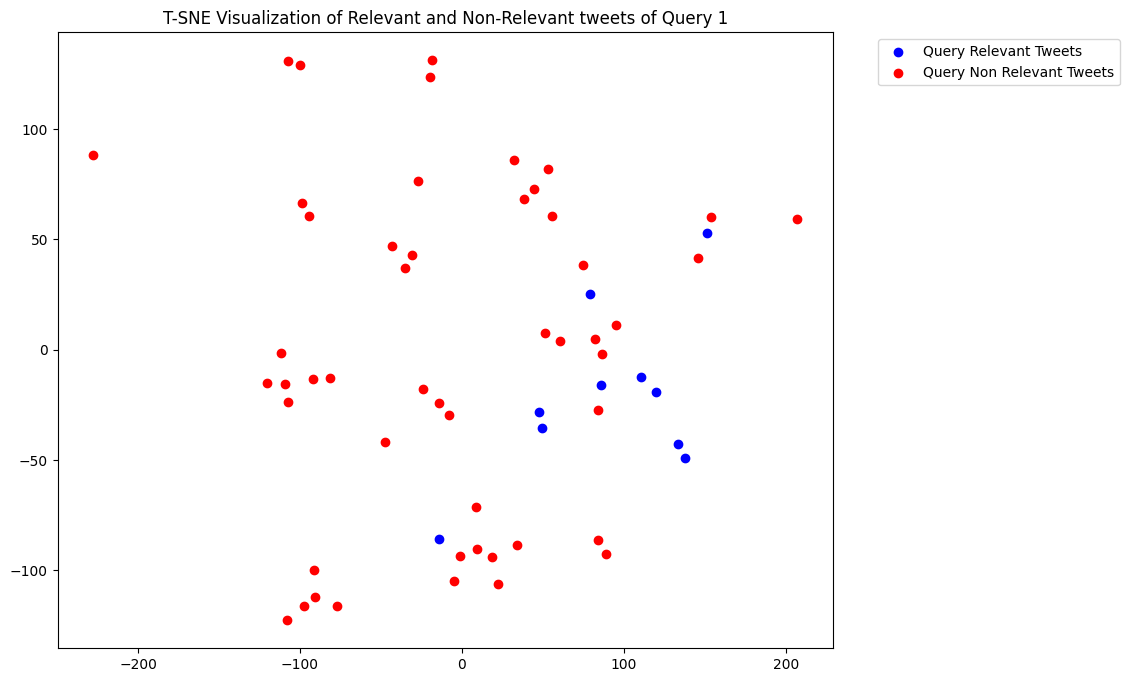

In [24]:
for query_id in search_results['query_id'].unique():
    # TF-IDF Vectorization
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Initialize TF-IDF vectorizer with a maximum of 5000 features
    tfidf_matrix_all = tfidf_vectorizer.fit_transform(all_relevant_nonrelevant_tweets[query_id-1])  # Apply vectorizer to all tweets to create TF-IDF matrix

    # T-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=2)  # Initialize T-SNE with 2 components, random seed for reproducibility, and perplexity 
    tsne_result_all = tsne.fit_transform(tfidf_matrix_all.toarray())  # Apply T-SNE to the TF-IDF matrix for all tweets

    # Separate T-SNE results for each set of tweets
    # Extract T-SNE results for relevant_tweets 
    tsne_result1 = tsne_result_all[:len(relevant_tweets_text[query_id])]

    # Extract T-SNE results for non_relevant_tweets 
    tsne_result2 = tsne_result_all[len(relevant_tweets_text[query_id]):]

    # Visualization
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result1[:, 0], tsne_result1[:, 1], marker='o', color='blue', label='Query Relevant Tweets')
    plt.scatter(tsne_result2[:, 0], tsne_result2[:, 1], marker='o', color='red', label='Query Non Relevant Tweets')

    plt.title('T-SNE Visualization of Relevant and Non-Relevant tweets of Query {}'.format(query_id))
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()